# Práctica 4: Reglas de Asociación

---

Iria Agulló Gómez: https://github.com/iriaagullo

Sara Porto Álvarez: https://github.com/saraportto

**Análisis del comercio minorista** aplicando algoritmos de aprendizaje de **reglas de asociación**.


El **dataset** (`groceries.csv`) utilizado es un listado de productos que incluye:
- nº de cliente
- fecha de transacción
- producto adquirido

---

El código deberá de ir acompañado de textos explicativos del trabajo realizado: decisiones tomadas (métricas, umbrales, segmentación del dataset para el análisis, etc. )



## **Imports**

Realizamos los imports e instalaciones necesarios.

In [50]:
!pip install mlxtend
!pip install openpyxl

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import warnings
from collections import Counter
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')


## **Tratamiento de los datos**

#### Carga del dataset

Realizamos la carga del dataset a través de la url dada; y leemos dicho csv con pandas

In [52]:
url = "http://linguarum.net/apau2/groceries.csv"
df = pd.read_csv(url, header=None) # lee archivo con pandas

#### Información inicial dataset

Se hace un análisis inicial del dataset dado. Conocemos la estructura del dataset viendo sus primeras filas con `df_head()`, y realizamos una exploración de la forma, tipos, presencia de nulos en los datos (entre otros).

In [53]:
### PRIMERAS FILAS
df.head()

,0,1,2
0,Member_number,Date,itemDescription
1,1808,21-07-2015,tropical fruit
2,2552,05-01-2015,whole milk
3,2300,19-09-2015,pip fruit
4,1187,12-12-2015,other vegetables


In [54]:
### FORMA dataset
df.shape

(38766, 3)

In [55]:
### TIPOS de datos dataset
df.dtypes

,0
0,object
1,object
2,object


In [56]:
### NULOS
df.isnull().sum()


,0
0,0
1,0
2,0


In [57]:
### NOMBRE cols
df.columns = ['Member_number', 'Date', 'itemDescription']

In [58]:
### CLIENTES ÚNICOS
df["Member_number"].nunique()

3899

In [59]:
### PRODUCTOS ÚNICOS
df["itemDescription"].nunique()

168

In [60]:
### INFO general del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38766 entries, 0 to 38765
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38766 non-null  object
 1   Date             38766 non-null  object
 2   itemDescription  38766 non-null  object
dtypes: object(3)
memory usage: 908.7+ KB


#### Conversión al formato transaccional

Creamos un nuevo dataframe en el que agrupamos productos por transacción (entendida como una compra de un cliente, `Member_number`, en un mismo día, `Date`). Cada transcacción contiene una lista de productos (`items`).

In [61]:
### GROUP BY por transacción (cliente+fecha)
grouped = df.groupby(['Member_number', 'Date'])['itemDescription'].apply(list).reset_index()

grouped.columns = ['Member_number', 'Date', 'Items'] # nuevos nombres columnas


In [62]:
### de nuevo, head
grouped.head()

,Member_number,Date,Items
0,1000,15-03-2015,"[sausage, whole milk, semi-finished bread, yog..."
1,1000,24-06-2014,"[whole milk, pastry, salty snack]"
2,1000,24-07-2015,"[canned beer, misc. beverages]"
3,1000,25-11-2015,"[sausage, hygiene articles]"
4,1000,27-05-2015,"[soda, pickled vegetables]"


#### Codificación con `TransactionEncoder`

Para poder trabajar con *Apriori* y *FP-Growth*, convertimos las listas de productos en una matriz booleana que represente la presencia o ausencia de cada producto (es decir, se hace una especie de *One-Hot encoding*).

Cada fila representa una transacción, y cada columna será un producto. El valor True/False de la casilla indicará si el producto está presente o no en la transacción. Esto debido a que es el formato reuquerido para los algoritmos de minería de reglas de asociación (como lo son *Apriori* y *FP-Growth*).

In [63]:
encoder = TransactionEncoder()
encoder_array = encoder.fit_transform(grouped['Items'])

df_encoded = pd.DataFrame(encoder_array, columns=encoder.columns_)

In [64]:
df_encoded.shape

(14964, 168)

In [65]:
df_encoded.head()

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## **Generación de *Itemsets* frecuentes y Reglas de asociación**

- Reglas obtenidas en el conjunto del dataset

- Reglas obtenidas en periodos concretos del año (cuatrimestre, semestre, verano, Navidad, etc)

---

Contrastar si hay variaciones en las reglas cuando se segmenta el dataset por periodos de tiempo. Por ejemplo: ¿las compras en Navidad producen reglas específicas? ¿Hay diferencias verano/invierno?
- Breve anáisis de las reglas obtenidas




### 1. *Apriori*

#### *Itemsets* más frecuentes

Establecemos `min_support`= 0.01; para poder considerar como frecuentes los items que aparecen más del 1% de las veces. No aparecían datos antes del 0.157 (que es el valor de support de la leche *entera*). La forma de averiguarlo fue de prueba y error.

Por lo que, para que el estudio sea interesante, nos interesa que el *support* sea así de bajo.

In [66]:
start_time_ap = time.time()

# apriori para itemsets más frecuentes
itemsets_ap = apriori(df_encoded,
                      min_support=0.01,
                      use_colnames=True
                      )

ap_execution_time = time.time() - start_time_ap

# tiempo que tarda apriori
print(f"Apriori: {ap_execution_time:.4f} segundos")


Apriori: 0.2294 segundos


Observamos los itemsets más frecuentes.

In [67]:
itemsets_ap.sort_values('support', ascending=False).head() # observar itemsets más frecuentes

,support,itemsets
62,0.157912,(whole milk)
40,0.122093,(other vegetables)
46,0.109997,(rolls/buns)
52,0.097100,(soda)
63,0.085873,(yogurt)


Graficamos un histograma con el valor de soporte (con información desde el valor de soporte igual a *minsup*, 0.01).

Text(0.5, 1.0, 'Soporte')

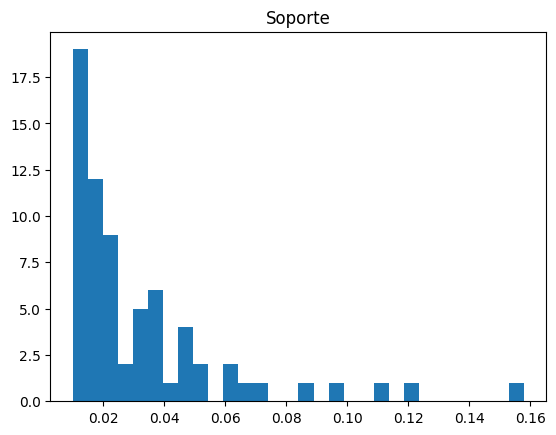

In [68]:
itemsets_ap.hist("support", grid=False, bins=30) # histograma soporte
plt.title("Soporte")

#### Reglas de asociación

Ahora pasaremos a producir las reglas de asociación con los listados de *itemsets* más frecuentes que ya generamos, con la medida de confianza.

El umbral tuvo que ser reducido hasta el valor de 0.01, donde obtuvimos 10 reglas de asociación. De nuevo, para comprobar el umbral el método fue de prueba y error.

In [69]:
# reglas de asociación apriori
rules_ap = association_rules(itemsets_ap,
                            metric="confidence",
                             min_threshold=0.01,
                             support_only=False
                             )

rules_ap.sort_values(by='confidence', ascending=False)[["antecedents", "consequents", "confidence", "support"]].head(10)

,antecedents,consequents,confidence,support
8,(yogurt),(whole milk),0.129961,0.011160
4,(rolls/buns),(whole milk),0.126974,0.013967
2,(other vegetables),(whole milk),0.121511,0.014836
6,(soda),(whole milk),0.119752,0.011628
0,(rolls/buns),(other vegetables),0.095990,0.010559
3,(whole milk),(other vegetables),0.093948,0.014836
5,(whole milk),(rolls/buns),0.088447,0.013967
1,(other vegetables),(rolls/buns),0.086481,0.010559
7,(whole milk),(soda),0.073635,0.011628
9,(whole milk),(yogurt),0.070673,0.011160


In [70]:
rules_ap.shape

(10, 14)

In [71]:
rules_ap.head(rules_ap.shape[0]) # observamos todas las reglas obtenidas

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(rolls/buns),(other vegetables),0.109997,0.122093,0.010559,0.095990,0.786206,1.0,-0.002871,0.971126,-0.234033,0.047662,-0.029733,0.091235
1,(other vegetables),(rolls/buns),0.122093,0.109997,0.010559,0.086481,0.786206,1.0,-0.002871,0.974257,-0.236495,0.047662,-0.026423,0.091235
2,(other vegetables),(whole milk),0.122093,0.157912,0.014836,0.121511,0.769482,1.0,-0.004444,0.958563,-0.254420,0.055948,-0.043228,0.107730
3,(whole milk),(other vegetables),0.157912,0.122093,0.014836,0.093948,0.769482,1.0,-0.004444,0.968937,-0.262403,0.055948,-0.032059,0.107730
4,(rolls/buns),(whole milk),0.109997,0.157912,0.013967,0.126974,0.804082,1.0,-0.003403,0.964563,-0.214927,0.055000,-0.036739,0.107711
5,(whole milk),(rolls/buns),0.157912,0.109997,0.013967,0.088447,0.804082,1.0,-0.003403,0.976359,-0.224412,0.055000,-0.024214,0.107711
6,(soda),(whole milk),0.097100,0.157912,0.011628,0.119752,0.758346,1.0,-0.003705,0.956648,-0.260862,0.047776,-0.045316,0.096694
7,(whole milk),(soda),0.157912,0.097100,0.011628,0.073635,0.758346,1.0,-0.003705,0.974670,-0.274529,0.047776,-0.025988,0.096694
8,(yogurt),(whole milk),0.085873,0.157912,0.011160,0.129961,0.822995,1.0,-0.002400,0.967874,-0.190466,0.047975,-0.033193,0.100317
9,(whole milk),(yogurt),0.157912,0.085873,0.011160,0.070673,0.822995,1.0,-0.002400,0.983644,-0.203445,0.047975,-0.016628,0.100317


Graficamos un histograma con los valores de confianza.

Text(0.5, 1.0, 'Confianza')

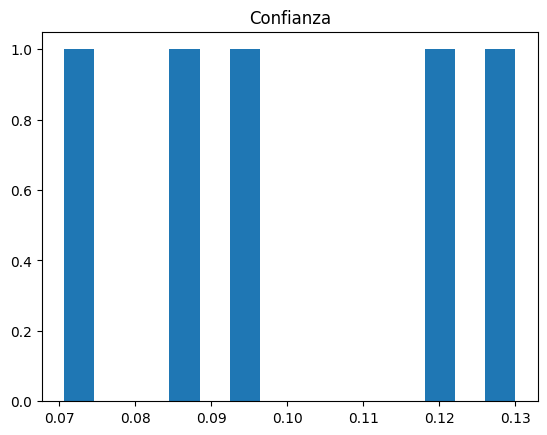

In [72]:
rules_ap.hist("confidence", grid=False, bins=30)
plt.title("Confianza")

### 2. *FP-Growth*

#### *Itemsets* más frecuentes

Haremos un procdimiento análogo al de *Apriori*, esta vez con *FP-Growth*.

In [73]:
start_time_fp = time.time()

# fp-growth para itemsets más frecuentes
itemsets_fp = apriori(df_encoded,
                      min_support=0.01,
                      use_colnames=True
                      )

fp_execution_time = time.time() - start_time_fp

# tiempo que tarda fp-growth
print(f"FP-Growth: {fp_execution_time:.4f} segundos")


FP-Growth: 0.3553 segundos


In [74]:
itemsets_fp.sort_values('support', ascending=False).head() # observar itemsets más frecuentes

,support,itemsets
62,0.157912,(whole milk)
40,0.122093,(other vegetables)
46,0.109997,(rolls/buns)
52,0.097100,(soda)
63,0.085873,(yogurt)


Text(0.5, 1.0, 'Soporte')

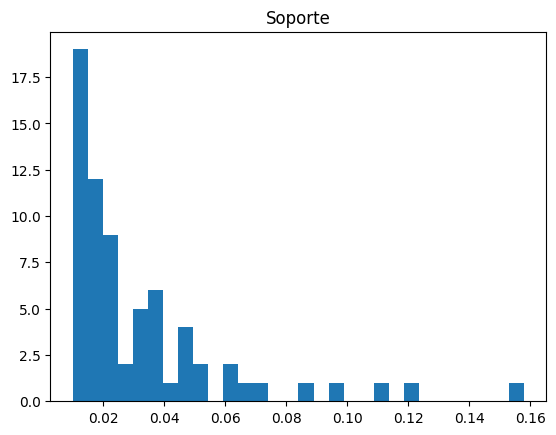

In [75]:
itemsets_fp.hist("support", grid=False, bins=30) # histograma soporte
plt.title("Soporte")

Los resultados de *itemsets* más frecuentes y soporte son (obviamente) los mismos que en el caso de *apriori*. A pesar de que, teóricamente, el *FP-Growth* debería ser más eficiente; lo cierto es que para este caso no se ha notado gran diferencia en cuanto a resultados en tiempo de ejecución.

#### Reglas de asociación

In [76]:
# reglas de asociación fp-growth
rules_fp = association_rules(itemsets_fp,
                            metric="confidence",
                             min_threshold=0.01,
                             support_only=False
                             )

rules_fp.sort_values(by='confidence', ascending=False)[["antecedents", "consequents", "confidence", "support"]].head(10)

,antecedents,consequents,confidence,support
8,(yogurt),(whole milk),0.129961,0.011160
4,(rolls/buns),(whole milk),0.126974,0.013967
2,(other vegetables),(whole milk),0.121511,0.014836
6,(soda),(whole milk),0.119752,0.011628
0,(rolls/buns),(other vegetables),0.095990,0.010559
3,(whole milk),(other vegetables),0.093948,0.014836
5,(whole milk),(rolls/buns),0.088447,0.013967
1,(other vegetables),(rolls/buns),0.086481,0.010559
7,(whole milk),(soda),0.073635,0.011628
9,(whole milk),(yogurt),0.070673,0.011160


In [77]:
rules_fp.shape

(10, 14)

In [78]:
rules_fp.head(rules_ap.shape[0]) # observamos todas las reglas obtenidas

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(rolls/buns),(other vegetables),0.109997,0.122093,0.010559,0.095990,0.786206,1.0,-0.002871,0.971126,-0.234033,0.047662,-0.029733,0.091235
1,(other vegetables),(rolls/buns),0.122093,0.109997,0.010559,0.086481,0.786206,1.0,-0.002871,0.974257,-0.236495,0.047662,-0.026423,0.091235
2,(other vegetables),(whole milk),0.122093,0.157912,0.014836,0.121511,0.769482,1.0,-0.004444,0.958563,-0.254420,0.055948,-0.043228,0.107730
3,(whole milk),(other vegetables),0.157912,0.122093,0.014836,0.093948,0.769482,1.0,-0.004444,0.968937,-0.262403,0.055948,-0.032059,0.107730
4,(rolls/buns),(whole milk),0.109997,0.157912,0.013967,0.126974,0.804082,1.0,-0.003403,0.964563,-0.214927,0.055000,-0.036739,0.107711
5,(whole milk),(rolls/buns),0.157912,0.109997,0.013967,0.088447,0.804082,1.0,-0.003403,0.976359,-0.224412,0.055000,-0.024214,0.107711
6,(soda),(whole milk),0.097100,0.157912,0.011628,0.119752,0.758346,1.0,-0.003705,0.956648,-0.260862,0.047776,-0.045316,0.096694
7,(whole milk),(soda),0.157912,0.097100,0.011628,0.073635,0.758346,1.0,-0.003705,0.974670,-0.274529,0.047776,-0.025988,0.096694
8,(yogurt),(whole milk),0.085873,0.157912,0.011160,0.129961,0.822995,1.0,-0.002400,0.967874,-0.190466,0.047975,-0.033193,0.100317
9,(whole milk),(yogurt),0.157912,0.085873,0.011160,0.070673,0.822995,1.0,-0.002400,0.983644,-0.203445,0.047975,-0.016628,0.100317


In [79]:
rules_ap.head(rules_ap.shape[0]) # observamos todas las reglas obtenidas

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(rolls/buns),(other vegetables),0.109997,0.122093,0.010559,0.095990,0.786206,1.0,-0.002871,0.971126,-0.234033,0.047662,-0.029733,0.091235
1,(other vegetables),(rolls/buns),0.122093,0.109997,0.010559,0.086481,0.786206,1.0,-0.002871,0.974257,-0.236495,0.047662,-0.026423,0.091235
2,(other vegetables),(whole milk),0.122093,0.157912,0.014836,0.121511,0.769482,1.0,-0.004444,0.958563,-0.254420,0.055948,-0.043228,0.107730
3,(whole milk),(other vegetables),0.157912,0.122093,0.014836,0.093948,0.769482,1.0,-0.004444,0.968937,-0.262403,0.055948,-0.032059,0.107730
4,(rolls/buns),(whole milk),0.109997,0.157912,0.013967,0.126974,0.804082,1.0,-0.003403,0.964563,-0.214927,0.055000,-0.036739,0.107711
5,(whole milk),(rolls/buns),0.157912,0.109997,0.013967,0.088447,0.804082,1.0,-0.003403,0.976359,-0.224412,0.055000,-0.024214,0.107711
6,(soda),(whole milk),0.097100,0.157912,0.011628,0.119752,0.758346,1.0,-0.003705,0.956648,-0.260862,0.047776,-0.045316,0.096694
7,(whole milk),(soda),0.157912,0.097100,0.011628,0.073635,0.758346,1.0,-0.003705,0.974670,-0.274529,0.047776,-0.025988,0.096694
8,(yogurt),(whole milk),0.085873,0.157912,0.011160,0.129961,0.822995,1.0,-0.002400,0.967874,-0.190466,0.047975,-0.033193,0.100317
9,(whole milk),(yogurt),0.157912,0.085873,0.011160,0.070673,0.822995,1.0,-0.002400,0.983644,-0.203445,0.047975,-0.016628,0.100317


In [80]:
rules_fp[rules_fp['antecedents'].apply(lambda x: len(x) <= 2)].sort_values(by='confidence', ascending=False)[["antecedents", "consequents", "confidence"]].head(10)

,antecedents,consequents,confidence
8,(yogurt),(whole milk),0.129961
4,(rolls/buns),(whole milk),0.126974
2,(other vegetables),(whole milk),0.121511
6,(soda),(whole milk),0.119752
0,(rolls/buns),(other vegetables),0.095990
3,(whole milk),(other vegetables),0.093948
5,(whole milk),(rolls/buns),0.088447
1,(other vegetables),(rolls/buns),0.086481
7,(whole milk),(soda),0.073635
9,(whole milk),(yogurt),0.070673


De nuevo, obtenemos los mismos resultados. Por lo tanto, a partir de ahora para el estudio utilizaremos las reglas obtenidas desde *FP-Growth*.

## **Reglas específicas**

Para hacer un estudio un tanto más profundo, vamos a observar las reglas específicas en distintas épocas del año, o en fechas especiales.


Primero será necesario hacer un preprocesado de las fechas, para poder utilizarlas.

In [81]:
grouped['Date'] = pd.to_datetime(grouped['Date'], dayfirst=True, errors='coerce') # conversión segura

grouped = grouped.dropna(subset=['Date']) # sin fechas inválidas


### Reglas obtenidas en Navidad

Entenderemos "Navidad" como las fechas que van del 10 de diciembre al 31 de diciembre.

In [82]:
# Época de NAVIDAD (1 diciembre al 31 de diciembre)
mask_navidad = (
    ((grouped['Date'].dt.month == 12) & (grouped['Date'].dt.day >= 10)) |
    ((grouped['Date'].dt.month == 12) & (grouped['Date'].dt.day <= 31))
)
grouped_navidad = grouped[mask_navidad].copy()

# Codificación
encoder_navidad = TransactionEncoder()
encoded_navidad = encoder_navidad.fit_transform(grouped_navidad['Items'])
df_encoded_navidad = pd.DataFrame(encoded_navidad, columns=encoder_navidad.columns_)

# FP-Growth y reglas
itemsets_navidad = fpgrowth(df_encoded_navidad, min_support=0.01, use_colnames=True)
rules_navidad = association_rules(itemsets_navidad, metric="confidence", min_threshold=0.01)

# Reglas ordenadas por confianza
rules_navidad.sort_values(by='confidence', ascending=False)[["antecedents", "consequents", "confidence", "support"]].head(10)


,antecedents,consequents,confidence,support
8,(tropical fruit),(whole milk),0.164384,0.010033
4,(rolls/buns),(other vegetables),0.162393,0.015886
0,(soda),(whole milk),0.148148,0.013378
2,(other vegetables),(whole milk),0.126582,0.016722
5,(other vegetables),(rolls/buns),0.120253,0.015886
3,(whole milk),(other vegetables),0.109290,0.016722
6,(rolls/buns),(whole milk),0.102564,0.010033
1,(whole milk),(soda),0.087432,0.013378
7,(whole milk),(rolls/buns),0.065574,0.010033
9,(whole milk),(tropical fruit),0.065574,0.010033


### Reglas obtenidas en Verano

Entenderemos "Verano" como las fechas que van de julio a agosto.

In [83]:
# Época de VERANO (1 junio – 31 agosto)
mask_verano = (
    (grouped['Date'].dt.month >= 6) & (grouped['Date'].dt.month <= 8)
)
grouped_verano = grouped[mask_verano].copy()

# Codificación
encoder_verano = TransactionEncoder()
encoded_verano = encoder_verano.fit_transform(grouped_verano['Items'])
df_encoded_verano = pd.DataFrame(encoded_verano, columns=encoder_verano.columns_)

# FP-Growth y reglas
itemsets_verano = fpgrowth(df_encoded_verano, min_support=0.01, use_colnames=True)
rules_verano = association_rules(itemsets_verano, metric="confidence", min_threshold=0.01)

# Reglas ordenadas por confianza
rules_verano.sort_values(by='confidence', ascending=False)[["antecedents", "consequents", "confidence", "support"]].head(10)


,antecedents,consequents,confidence,support
6,(soda),(whole milk),0.134409,0.013017
8,(yogurt),(whole milk),0.121387,0.010935
0,(rolls/buns),(whole milk),0.121212,0.012497
4,(other vegetables),(whole milk),0.120083,0.015100
2,(rolls/buns),(other vegetables),0.108586,0.011195
5,(whole milk),(other vegetables),0.093851,0.015100
3,(other vegetables),(rolls/buns),0.089027,0.011195
7,(whole milk),(soda),0.080906,0.013017
1,(whole milk),(rolls/buns),0.077670,0.012497
9,(whole milk),(yogurt),0.067961,0.010935


### Reglas obtenidas para el 4 de julio

Asumiendo que se trata de un dataset con datos de EE.UU., consideramos relevante la fecha del 4 de julio para conocer las reglas generadas en esa fecha festiva. Tomamos los datos de días de alrededor a esta fecha (del 2 al 5 de julio).

In [84]:
# Alrededor del 4 DE JULIO
mask_4_julio = (
    (grouped['Date'].dt.month == 7) &
    (grouped['Date'].dt.day >= 2) &
    (grouped['Date'].dt.day <= 5)
)
grouped_4_julio = grouped[mask_4_julio].copy()

# Codificación
encoder_4_julio = TransactionEncoder()
encoded_4_julio = encoder_4_julio.fit_transform(grouped_4_julio['Items'])
df_encoded_4_julio = pd.DataFrame(encoded_4_julio, columns=encoder_4_julio.columns_)

# FP-Growth y reglas
itemsets_4_julio = fpgrowth(df_encoded_4_julio, min_support=0.01, use_colnames=True)
rules_4_julio = association_rules(itemsets_4_julio, metric="confidence", min_threshold=0.01)

# Reglas más relevantes
rules_4_julio.sort_values(by='confidence', ascending=False)[["antecedents", "consequents", "confidence", "support"]].head(10)


,antecedents,consequents,confidence,support
47,"(tropical fruit, fruit/vegetable juice)",(domestic eggs),1.000000,0.012821
63,(beverages),(soda),1.000000,0.012821
48,"(fruit/vegetable juice, domestic eggs)",(tropical fruit),1.000000,0.012821
65,(flower (seeds)),(rolls/buns),1.000000,0.012821
46,"(tropical fruit, domestic eggs)",(fruit/vegetable juice),1.000000,0.012821
0,(butter milk),(bottled water),0.666667,0.012821
40,(UHT-milk),(whole milk),0.500000,0.012821
30,(chocolate),(beef),0.400000,0.012821
32,(beef),(newspapers),0.400000,0.012821
28,(citrus fruit),(fruit/vegetable juice),0.400000,0.012821


## **Conclusiones sobre las reglas obtenidas**

**En general**, las reglas más fuertes en cuanto a confianza giran en torno a productos básicos, lo que sugiere patrones de consumo estables y cotidianos.
* (yogurt) → (whole milk)
* (rolls/buns) → (whole milk)
* (other vegetables) → (whole milk)


También destacamos que la leche entera (whole milk) es el producto de consumo más habitual, lo cual ya habíamos observado al analizar el dataset y sus itemsets más frecuentes.


---

En reglas de **Navidad** encontramos nuevas combinaciones como:

* (tropical fruit) → (whole milk) con 16.4% de confianza.
* (rolls/buns) → (other vegetables) con 16.2% de confianza.


Aunque la leche se sigue manteniendo como un producto central, hay una ligera orientación hacia productos más festivos, como pueden ser las frutas tropicales (quizás para hacer algún postre) o los refrescos.

Además, hay una mayor confianza en las reglas en general, lo que denota unos patrones más marcados que al compararlos con el dataset completo.

---

En **Verano**, las reglas son bastante similares a las generales (donde los productos como la soda, yogurt o leche entera siguen predominando).

A pesar de ello, es cierto que la confianza aumenta en reglas como (soda) → (whole milk); que es esperable en épocas del año con clima más cálido (cuando el consumo de bebidas es mayor).

Las diferencias, por lo tanto, con respecto al patrón general, son muy ligeras.

---


Para encontrar algún patrón muy marcado, decidimos escoger alguna fecha concreta. Aunque enmarcado en el verano, dado que el **4 de julio** es el festivo por excelencia en EE.UU. (de donde asumimos que era el dataset), pensamos que podría ser interesante analizar las tendencias de consumo en esta fecha.


Encontramos patrones más distintos y con reglas de confianza del 100%:

* (tropical fruit, fruit/vegetable juice) → (domestic eggs)

* (flower (seeds)) → (rolls/buns)

* (fruit/vegetable juice, domestic eggs) → (tropical fruit)


Al tratarse de una ventana de tiempo tan pequeña y específica, algunos productos se compran siempre conjuntamente.


Además, también hay algunos productos menos comunes y curiosos en otras reglas, que no habían aparecido hasta ahora. Como por ejemplo:

* (beef) → (newspapers)

* (flower (seeds)) → (rolls/buns)

* (chocolate) → (beef)


Son reglas que denotan comportamientos específicos en esta fecha, que probablemente estén influenciados por celebraciones y barbacoas. Aunque con menor soporte, la confianza es muy elevada (lo cual refleja que es una muestra pequeña pero bastante homogénea).

---

Con todo, podemos concluir que la leche entera es un producto central en casi todas las épocas; reflejando así el hehco de que es un bien básico.


En Navidad hay un leve desplazamiento hacia compbinaciones más "especiales" que incluyen frutas tropicales y refrescos.

En Verano, por el contrario, el comportamiento es más similar al general (a pesar de ligeras alzas en productos frescos y bebidas).

El 4 de julio destaca por tener patrones específicos y reglas de confianza perfecta (aunque con bajo soporte):